In [6]:
# mamba activate ros2

import os
import json
import argparse
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from std_msgs.msg import String
import rosbag2_py
# from mcap.reader import make_reader
# from mcap_protobuf.decoder import DecoderFactory
from nuscenes.nuscenes import NuScenes
import nuscenes.utils.splits as nuscenes_splits
import numpy as np
import matplotlib.pyplot as plt
import gtsam
from functools import partial
from typing import List, Optional
import pandas as pd

In [10]:
nuscenes_dir = '/home/jd/nuScenes/data'
# dataset = 'v1.0-trainval'
dataset = 'v1.0-mini'
split_name = 'mini_train'

In [11]:
nusc = NuScenes(version=dataset, dataroot=nuscenes_dir, verbose=True)
split = eval('nuscenes_splits.' + split_name)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.404 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [30]:
for scene_name in split:
    print(scene_name)
    for idx in range(len(nusc.scene)):
        if nusc.scene[idx]["name"]==scene_name:
            scene = nusc.scene[idx]

    cur_sample = nusc.get("sample", scene["first_sample_token"])  
    epoch = 0
    
    while cur_sample is not None:
        print(epoch)

        # TODO - get timestamp of epoch
        
        for annotation_id in cur_sample["anns"]:
            ann = nusc.get("sample_annotation", annotation_id)

            # TODO - if objects[ann_id]

        cur_sample = nusc.get("sample", cur_sample["next"]) if cur_sample.get("next") != "" else None
        epoch +=1
    print()

scene-0061
0
1fa93b757fc74fb197cdd60001ad8abf
1fa93b757fc74fb197cdd60001ad8abf
fd69059b62a3469fbaef25340c0eab7f
1fa93b757fc74fb197cdd60001ad8abf
85abebdccd4d46c7be428af5a6173947
fc95c87b806f48f8a1faea2dcc2222a4
1fa93b757fc74fb197cdd60001ad8abf
fd69059b62a3469fbaef25340c0eab7f
1fa93b757fc74fb197cdd60001ad8abf
653f7efbb9514ce7b81d44070d6208c1
653f7efbb9514ce7b81d44070d6208c1
1fa93b757fc74fb197cdd60001ad8abf
1fa93b757fc74fb197cdd60001ad8abf
1fa93b757fc74fb197cdd60001ad8abf
1fa93b757fc74fb197cdd60001ad8abf
653f7efbb9514ce7b81d44070d6208c1
fd69059b62a3469fbaef25340c0eab7f
1fa93b757fc74fb197cdd60001ad8abf
6021b5187b924d64be64a702e5570edf
fd69059b62a3469fbaef25340c0eab7f
1fa93b757fc74fb197cdd60001ad8abf
653f7efbb9514ce7b81d44070d6208c1
653f7efbb9514ce7b81d44070d6208c1
653f7efbb9514ce7b81d44070d6208c1
85abebdccd4d46c7be428af5a6173947
653f7efbb9514ce7b81d44070d6208c1
fedb11688db84088883945752e480c2c
1fa93b757fc74fb197cdd60001ad8abf
1fa93b757fc74fb197cdd60001ad8abf
653f7efbb9514ce7b81d44070d6208

# Find distance threshold

In [4]:
# FIND THRESHOLD
# Initialize global parameters
dist_thresh = np.finfo(np.float64).max

# for each scene in directory
scene_path = '/home/jd/tracking_ws/src/ros_tracking/data/detections/NuScenes-v1.0-mini-scene-0061-megvii.json'
scene = 'NuScenes-v1.0-mini-scene-0061-megvii'

# load dict file for scene
scene_dict = json.load(open(scene_path))

# for t in scene
scene_df = pd.DataFrame(columns=['scene','epoch','obj','det','dx','dy','dz','dp'])
for epoch in scene_dict.keys():
    print('epoch')
    print(epoch)

    # get num of detections and states
    n_det = len(scene_dict[epoch]['detections'].keys())
    n_obj = len(scene_dict[epoch]['objects'].keys())
    
    print('init dist matrix')
    dist_matrix = np.zeros((n_obj,n_det))        
    
    # iterate through states
    for obj_idx, obj_key in enumerate(scene_dict[epoch]['objects'].keys()):
        obj = scene_dict[epoch]['objects'][obj_key]
        
        # Get object spatial information
        obj_pos = np.array([obj['state']['pos']['x'], obj['state']['pos']['y'], obj['state']['pos']['z']])

        # iterate through detections
        for det_idx, det_key in enumerate(scene_dict[epoch]['detections'].keys()):
            det = scene_dict[epoch]['detections'][det_key]
#             print(det.keys()) # ['stamp', 'category', 'score', 'pos', 'rot', 'size', 'att']
            det_pos = np.array([det['pos']['x'], det['pos']['y'], det['pos']['z']])
    
            dist_matrix[obj_idx,det_idx] = np.linalg.norm(obj_pos - det_pos)
    
    print('Final dist matrix')

    # Now, matrix is formed. Find new threshold
    masked_dist = np.ma.masked_less(dist_matrix,dist_thresh)

    print(sum(masked_dist.mask)>1)
    
    while any(sum(masked_dist.mask)>3): # two tracks to one detection!
        dist_thresh = np.min((np.where(masked_dist.mask,dist_matrix,0).max(),dist_thresh))
        masked_dist = np.ma.masked_less(dist_matrix,dist_thresh)
        print('new threshold:')
        print(dist_thresh)
        print()
        
            

epoch
0
init dist matrix
Final dist matrix
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
new threshold:
135.30207605072624

new threshold:
130.26026840422355

new threshold:
127.2906401413146

new threshold:
126

new threshold:
90.68210270775783

new threshold:
90.65532636835133

new threshold:
90.63448696636904

new threshold:
90.5582370681512

new threshold:
90.5050637154037

new threshold:
90.44940403280994

new threshold:
90.41051977055785

new threshold:
90.4062793340189

new threshold:
90.37892339466383

new threshold:
90.22255390285264

new threshold:
90.21600663401199

new threshold:
90.20365001470007

new threshold:
90.1245545423858

new threshold:
90.12213086194794

new threshold:
90.11372278721609

new threshold:
90.00739022956446

new threshold:
89.98333964036294

new threshold:
89.98111875370519

new threshold:
89.94663655497772

new threshold:
89.8977670117393

new threshold:
89.78622324211092

new threshold:
89.76406492099925

new threshold:
89.73850255312192

new threshold:
89.69257881382843

new threshold:
89.66917089827166

new threshold:
89.63932848376777

new threshold:
89.60725777254275

new threshold:
89.5043952557758

new threshold:
89.50009798688727

new threshold:
89.49

new threshold:
78.28762490606077

new threshold:
78.28210539343796

new threshold:
78.26316712309512

new threshold:
78.22296900450324

new threshold:
78.21276477833197

new threshold:
78.19837797694984

new threshold:
78.19429482050964

new threshold:
78.17964607901312

new threshold:
78.17715762651676

new threshold:
78.10581360223591

new threshold:
78.09482642713093

new threshold:
78.07908541153373

new threshold:
78.07571519985262

new threshold:
78.05077131600177

new threshold:
78.04802352067226

new threshold:
78.02551116415638

new threshold:
78.00835098548148

new threshold:
77.96023987090183

new threshold:
77.94024906501069

new threshold:
77.85973865252559

new threshold:
77.85031331547181

new threshold:
77.84681258791765

new threshold:
77.84512695451856

new threshold:
77.84398533040422

new threshold:
77.8416624601251

new threshold:
77.7884025077358

new threshold:
77.74007363238816

new threshold:
77.71754629506817

new threshold:
77.69564586934389

new threshold:
7

new threshold:
68.04281094988177

new threshold:
68.02256455915331

new threshold:
67.99587828065565

new threshold:
67.95901655090212

new threshold:
67.93414567807869

new threshold:
67.93031386112094

new threshold:
67.82274773151413

new threshold:
67.79291217376867

new threshold:
67.77836636453797

new threshold:
67.77274477791171

new threshold:
67.74226957161548

new threshold:
67.73920750283129

new threshold:
67.7126143279639

new threshold:
67.70516577911545

new threshold:
67.66961061633386

new threshold:
67.62582337181932

new threshold:
67.62131347049927

new threshold:
67.5629646754605

new threshold:
67.55192663171994

new threshold:
67.53475163626568

new threshold:
67.52913333851104

new threshold:
67.52254857602844

new threshold:
67.52162616783103

new threshold:
67.51925332832111

new threshold:
67.51113127498046

new threshold:
67.5013587626911

new threshold:
67.49844767343761

new threshold:
67.4646478875814

new threshold:
67.46393403927283

new threshold:
67.

new threshold:
60.61488002181544

new threshold:
60.613158726871006

new threshold:
60.581282074377675

new threshold:
60.571233076118375

new threshold:
60.55155304847086

new threshold:
60.541708454550175

new threshold:
60.52688367737897

new threshold:
60.51908625655979

new threshold:
60.51499308769229

new threshold:
60.49068106027324

new threshold:
60.483800255141276

new threshold:
60.468230815702945

new threshold:
60.45632497357878

new threshold:
60.448203057379196

new threshold:
60.4465235366583

new threshold:
60.42373560426874

new threshold:
60.42321023038617

new threshold:
60.40721800334863

new threshold:
60.40551200208718

new threshold:
60.40357294524225

new threshold:
60.379639307559174

new threshold:
60.37674639059425

new threshold:
60.376366517566254

new threshold:
60.360009643809626

new threshold:
60.352359484859235

new threshold:
60.343910963686454

new threshold:
60.31662578879377

new threshold:
60.31507291265118

new threshold:
60.314915221126306

ne

new threshold:
55.02418396269516

new threshold:
55.02313004984926

new threshold:
55.020536159609286

new threshold:
55.01917048533773

new threshold:
55.017459727728976

new threshold:
55.011643382228186

new threshold:
54.971168794583626

new threshold:
54.96631750360319

new threshold:
54.95823276393277

new threshold:
54.950566469280695

new threshold:
54.94810476273447

new threshold:
54.94012551027846

new threshold:
54.929084373179435

new threshold:
54.92527253911048

new threshold:
54.91098356969023

new threshold:
54.90754124689107

new threshold:
54.8903572689647

new threshold:
54.8688574436464

new threshold:
54.86278178560799

new threshold:
54.86217750379667

new threshold:
54.85375662411853

new threshold:
54.85367277987884

new threshold:
54.84604547380752

new threshold:
54.833525936983825

new threshold:
54.829055609745666

new threshold:
54.82701992100827

new threshold:
54.819083294765946

new threshold:
54.81612906970578

new threshold:
54.80366802509667

new thr

new threshold:
50.78496026646165

new threshold:
50.78073200133509

new threshold:
50.777276699794704

new threshold:
50.765705859051224

new threshold:
50.765164535177476

new threshold:
50.75419705542377

new threshold:
50.75062256592067

new threshold:
50.7425259052857

new threshold:
50.737229827924295

new threshold:
50.7321903242796

new threshold:
50.72172001659928

new threshold:
50.72009518267645

new threshold:
50.710012471788694

new threshold:
50.707622584499845

new threshold:
50.70350604491399

new threshold:
50.697297622865975

new threshold:
50.68754997985286

new threshold:
50.67934630130987

new threshold:
50.67856225720971

new threshold:
50.67043690854115

new threshold:
50.6668768843893

new threshold:
50.62071028537095

new threshold:
50.61332930508513

new threshold:
50.6060240676642

new threshold:
50.60356606518843

new threshold:
50.587421037781574

new threshold:
50.58706627255897

new threshold:
50.58569066158362

new threshold:
50.5703733233413

new thresho

new threshold:
46.51853825510123

new threshold:
46.516446863317256

new threshold:
46.51611319092339

new threshold:
46.504845879289384

new threshold:
46.50396885969372

new threshold:
46.493867153735586

new threshold:
46.49096994645728

new threshold:
46.46159374976936

new threshold:
46.447828499168935

new threshold:
46.4456275066183

new threshold:
46.44277753104102

new threshold:
46.44264815157248

new threshold:
46.43725711795578

new threshold:
46.42552666082737

new threshold:
46.40289174310848

new threshold:
46.39915212650699

new threshold:
46.387913488054494

new threshold:
46.3770751148541

new threshold:
46.3725799539693

new threshold:
46.357447746493335

new threshold:
46.334304754354925

new threshold:
46.333885694236784

new threshold:
46.33027648213219

new threshold:
46.320522414273235

new threshold:
46.311132253042246

new threshold:
46.31071773111846

new threshold:
46.3036552352214

new threshold:
46.30251505887244

new threshold:
46.28782756142951

new thre

new threshold:
42.13121372552939

new threshold:
42.11991599662167

new threshold:
42.113484788154985

new threshold:
42.11253002668173

new threshold:
42.10322550326091

new threshold:
42.088354976367086

new threshold:
42.083603641522394

new threshold:
42.07130521032011

new threshold:
42.06918278142348

new threshold:
42.06619389766436

new threshold:
42.06297189473862

new threshold:
42.059142235315036

new threshold:
42.02299743542214

new threshold:
42.01702933455647

new threshold:
41.99918508764849

new threshold:
41.998854141656864

new threshold:
41.98072017207793

new threshold:
41.97209540326735

new threshold:
41.95919757714408

new threshold:
41.957209427247015

new threshold:
41.95241039043716

new threshold:
41.944697999487815

new threshold:
41.932520298235005

new threshold:
41.929802098989235

new threshold:
41.92005155016718

new threshold:
41.91945554915709

new threshold:
41.88356457756984

new threshold:
41.86807012103966

new threshold:
41.862696094594355

new 

new threshold:
37.20347522899361

new threshold:
37.20271966740989

new threshold:
37.19030427565626

new threshold:
37.187661033645114

new threshold:
37.18286085702009

new threshold:
37.17401749396997

new threshold:
37.14806072040518

new threshold:
37.13756920250527

new threshold:
37.12572067121431

new threshold:
37.124990409859265

new threshold:
37.122956304598986

new threshold:
37.100342289752405

new threshold:
37.094315426396406

new threshold:
37.08510438188961

new threshold:
37.082882758861736

new threshold:
37.074583770322896

new threshold:
37.07235402195001

new threshold:
37.06037305243687

new threshold:
37.0577160642963

new threshold:
37.04370882615973

new threshold:
37.03294427557639

new threshold:
37.01321473733534

new threshold:
37.01016875562898

new threshold:
37.00957371552076

new threshold:
37.00242909448495

new threshold:
36.99971254520227

new threshold:
36.99240619092017

new threshold:
36.99074883097803

new threshold:
36.984960039422795

new thr

new threshold:
33.20004251449495

new threshold:
33.19529084596478

new threshold:
33.1948931519641

new threshold:
33.176799877794984

new threshold:
33.14911153999993

new threshold:
33.136136664027475

new threshold:
33.133100163029034

new threshold:
33.13147362759787

new threshold:
33.12917082245697

new threshold:
33.11908007795658

new threshold:
33.11307418185181

new threshold:
33.11032234797754

new threshold:
33.08599176354622

new threshold:
33.08152506299188

new threshold:
33.07750071956619

new threshold:
33.06019892146586

new threshold:
33.056347148339846

new threshold:
33.05353831405279

new threshold:
33.05027543631377

new threshold:
33.04846345846652

new threshold:
33.042873203266744

new threshold:
33.04150443297406

new threshold:
33.020243323214075

new threshold:
33.01857158381917

new threshold:
33.008864675875486

new threshold:
33.0075736143155

new threshold:
32.991772076378034

new threshold:
32.974087458066606

new threshold:
32.97107886378868

new thr

new threshold:
29.719576844162855

new threshold:
29.709652030647312

new threshold:
29.706549237734396

new threshold:
29.70061720341776

new threshold:
29.689438652279936

new threshold:
29.68630758566899

new threshold:
29.68441268394881

new threshold:
29.681323186029385

new threshold:
29.67165264346685

new threshold:
29.671294559553075

new threshold:
29.65286267418979

new threshold:
29.647858654153506

new threshold:
29.640416699704804

new threshold:
29.630972538381148

new threshold:
29.62806300750981

new threshold:
29.627774665669598

new threshold:
29.62685640642713

new threshold:
29.622009569561598

new threshold:
29.61159781481616

new threshold:
29.608387795701447

new threshold:
29.606546147739

new threshold:
29.60573472965384

new threshold:
29.5952068274681

new threshold:
29.582558834695025

new threshold:
29.575929234281954

new threshold:
29.574746439699876

new threshold:
29.557577395936704

new threshold:
29.551356957985032

new threshold:
29.540867383089218



new threshold:
26.505345168502206

new threshold:
26.50199827712581

new threshold:
26.499503027888295

new threshold:
26.49309568383647

new threshold:
26.491828407733713

new threshold:
26.484896156977257

new threshold:
26.465001058318673

new threshold:
26.46457426574683

new threshold:
26.459600676591094

new threshold:
26.458795889445184

new threshold:
26.4570934518734

new threshold:
26.453183132441087

new threshold:
26.440312044464054

new threshold:
26.423823717450816

new threshold:
26.422315258213477

new threshold:
26.422073384985243

new threshold:
26.416812896601552

new threshold:
26.415488783073222

new threshold:
26.405884569773516

new threshold:
26.40023121288843

new threshold:
26.396627145248747

new threshold:
26.396479022781115

new threshold:
26.396177299864547

new threshold:
26.38442395849563

new threshold:
26.377852709399278

new threshold:
26.37403659872136

new threshold:
26.37337217431263

new threshold:
26.36510296957304

new threshold:
26.36356512698

new threshold:
23.041637574880895

new threshold:
23.035122208497423

new threshold:
23.034523469619046

new threshold:
23.03251282500461

new threshold:
23.019120270646336

new threshold:
23.018658150981793

new threshold:
23.01189953987174

new threshold:
23.011761918049338

new threshold:
22.998472113203537

new threshold:
22.99252032237859

new threshold:
22.988128181741317

new threshold:
22.98489636661874

new threshold:
22.97227577402462

new threshold:
22.961228794480093

new threshold:
22.957001487542463

new threshold:
22.95428933601699

new threshold:
22.944968805609253

new threshold:
22.94424534381635

new threshold:
22.93887543011472

new threshold:
22.93812663746873

new threshold:
22.935167177451056

new threshold:
22.935161715290704

new threshold:
22.92213199594591

new threshold:
22.917971964770018

new threshold:
22.90891134855465

new threshold:
22.9027904610014

new threshold:
22.8984026863109

new threshold:
22.892969868305794

new threshold:
22.890161964659313



new threshold:
18.846791335968135

new threshold:
18.84579339884337

new threshold:
18.840613531664133

new threshold:
18.835028684454336

new threshold:
18.834750951110827

new threshold:
18.820061015070745

new threshold:
18.818087183074194

new threshold:
18.80984533615327

new threshold:
18.809744054353967

new threshold:
18.809656558116053

new threshold:
18.803084763175164

new threshold:
18.80204400502411

new threshold:
18.795452820614283

new threshold:
18.793145430892604

new threshold:
18.790025933941386

new threshold:
18.769049056242565

new threshold:
18.766747477877782

new threshold:
18.751388662133444

new threshold:
18.741654573690237

new threshold:
18.719431170003237

new threshold:
18.707697491883224

new threshold:
18.702166199995194

new threshold:
18.68958040532219

new threshold:
18.67799902450978

new threshold:
18.67734821479111

new threshold:
18.668715291620913

new threshold:
18.664686664554562

new threshold:
18.66355193924781

new threshold:
18.661266878

new threshold:
15.042901253139933

new threshold:
15.04249933523298

new threshold:
15.040582104254225

new threshold:
15.039719232003286

new threshold:
15.015768861981835

new threshold:
15.013408168254548

new threshold:
15.012999843857672

new threshold:
15.007512047195053

new threshold:
15.004266861293877

new threshold:
15.002035971789077

new threshold:
15.002002096099403

new threshold:
14.982918790300799

new threshold:
14.979883519804547

new threshold:
14.971084731358532

new threshold:
14.96068731344803

new threshold:
14.950757531154045

new threshold:
14.94686850421748

new threshold:
14.936269170231013

new threshold:
14.935816286264759

new threshold:
14.935341687846417

new threshold:
14.89411883445139

new threshold:
14.885837664096146

new threshold:
14.88199550773734

new threshold:
14.878893681819875

new threshold:
14.872809054109409

new threshold:
14.869694650390983

new threshold:
14.869001877000986

new threshold:
14.867366496229687

new threshold:
14.8661846

new threshold:
10.875318273473809

new threshold:
10.872296164392878

new threshold:
10.869130961730505

new threshold:
10.86046586526849

new threshold:
10.84645222120804

new threshold:
10.835839180411428

new threshold:
10.830938901718032

new threshold:
10.80218751081237

new threshold:
10.797696249876035

new threshold:
10.77966133336921

new threshold:
10.76569498157202

new threshold:
10.764025779851433

new threshold:
10.755465131983698

new threshold:
10.754472277312402

new threshold:
10.747882543826494

new threshold:
10.744986778619003

new threshold:
10.73811573692763

new threshold:
10.721471065190954

new threshold:
10.692348017673703

new threshold:
10.69019647475922

new threshold:
10.659090234402951

new threshold:
10.638646440790323

new threshold:
10.628886916477244

new threshold:
10.620404772276022

new threshold:
10.61977594100098

new threshold:
10.586310681165862

new threshold:
10.584506101587575

new threshold:
10.574049707621063

new threshold:
10.5609605988

new threshold:
5.372225489568374

new threshold:
5.3263050248468575

new threshold:
5.2961729513502185

new threshold:
5.255055034646318

new threshold:
5.248681125230204

new threshold:
5.2115319535184375

new threshold:
5.192098233610672

new threshold:
5.134822002299992

new threshold:
5.131387331788519

new threshold:
5.0655084191799435

new threshold:
5.05856034534182

new threshold:
5.031601399330079

new threshold:
5.009930617267148

new threshold:
5.006805449319535

new threshold:
4.96133617406301

new threshold:
4.957530811018683

new threshold:
4.950781442647382

new threshold:
4.944080323376086

new threshold:
4.9396289655291685

new threshold:
4.90013546269844

new threshold:
4.891188882149587

new threshold:
4.860517677963857

new threshold:
4.850941106934537

new threshold:
4.826424348409452

new threshold:
4.817479617073259

new threshold:
4.810764978319223

new threshold:
4.789476959969573

new threshold:
4.7640506019114905

new threshold:
4.731032005953923

new thresho

Final dist matrix
[False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True False
 False  True  True  True  True  True  True  True  True  True  True False
 False  True  True  True False  True  True False  True False False False
  True  True  True  True False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False  True False False False False False
 False False False False False False False  True False  True False False
 False  True  True False  True  True  True  True False  True False False
  True False False False False False False False False  True False False
 False False False False False False False  True  True False False False
 False False False False False Fa

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False  True False False False  True False
 False  True False  True False False  True False  True False  True False
 False  True False  True  True False False False  True False False False
  True False False False False False False False False False False False
 False False False False False False  True False False False  True False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False  True  True False  True
  True  True  True False  True  True  True False  True  True False False
 False False False  True False  True  True  True False False False False
 False False False False  True False  True  True False False False False
 False False False False False False False False Fa

Final dist matrix
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False  True False False False  True False False False False False False
  True False False False False False False False False False False  True
 False False False False False False False False  True False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False  True False  True False False False  True
 False  True False False False False  True False False False False False
 False  True  True False False Fa

Final dist matrix
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False  True False False False  True False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False  True False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False Fa

Final dist matrix
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
  True False False False False False False False  True False  True False
 False False False False False False False  True  True False False False
 False  True False False False False False False False False False False
 False False False False  True False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True False False  True
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False  T

Final dist matrix
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False  True False False  True False
 False False False  True False False False False False False False False
 False  True False False False Fa

In [5]:
print((masked_dist.mask.shape))
print(sum(masked_dist.mask)) # length of detections
print(sum(sum(masked_dist.mask))) # n of matches
print(dist_thresh)

print(sum(sum(masked_dist.mask))/len(sum(masked_dist.mask)))

(77, 202)
[1 1 1 0 2 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 1 0 0 0 0 2 0 1 0 1 1
 2 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 2
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 2 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
90
0.8681006360031933
0.44554455445544555


In [6]:
print(dist_thresh) # 0.6310972784727102 for 2 dets


0.8681006360031933


In [7]:
# for each scene in directory
scene_path = '/home/jd/tracking_ws/src/ros_tracking/data/detections/NuScenes-v1.0-mini-scene-0061-megvii.json'
scene = 'NuScenes-v1.0-mini-scene-0061-megvii'

# load dict file for scene
scene_dict = json.load(open(scene_path))

# for t in scene
scene_df = pd.DataFrame(columns=['scene','epoch','obj','det','dx','dy','dz','dp'])
for epoch in scene_dict.keys():

    # get num of detections and states
    n_det = len(scene_dict[epoch]['detections'].keys())
    n_obj = len(scene_dict[epoch]['objects'].keys())
    
    dist_matrix = np.zeros()

    # iterate through states
    for obj_key in scene_dict[epoch]['objects'].keys():
        obj = scene_dict[epoch]['objects'][obj_key]
        
        # Get object spatial information
        obj_pos = np.array([obj['state']['pos']['x'], obj['state']['pos']['y'], obj['state']['pos']['z']])

        # iterate through detections
        for det_key in scene_dict[epoch]['detections'].keys():
            det = scene_dict[epoch]['detections'][det_key]
#             print(det.keys()) # ['stamp', 'category', 'score', 'pos', 'rot', 'size', 'att']
            det_pos = np.array([obj['state']['pos']['x'], obj['state']['pos']['y'], obj['state']['pos']['z']])
    
    
            # Add row to dataframe for later processing
            dp = obj_pos - det_pos
            row = pd.DataFrame([[scene,epoch,obj_key,det_key,dp[0],dp[1],dp[2],np.linalg.norm(dp)]],
                               columns=['scene','epoch','obj','det','dx','dy','dz','dp'])
            scene_df = pd.concat([scene_df,row],ignore_index=True)
    
            

TypeError: zeros() missing required argument 'shape' (pos 0)

In [ ]:
# plot the distribution of dp

# Traverse all files

In [98]:
mcap_path = '/home/jd/nuscenes2mcap/output'

In [99]:
# Iterate through mcap files and write detections
for root, _,files in os.walk(mcap_path,topdown=True):
    for file in files:

        # Get input filepath
        in_file = os.path.join(root,file)
        print(in_file)

/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1077-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0553-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1100-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1094-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0061-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0655-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0796-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0103-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0757-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0916-megvii.mcap


# Examine a single file

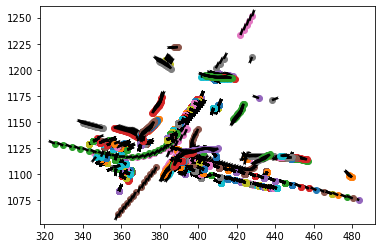

In [103]:
for key in objects:
    obj = objects[key]

    x = np.zeros(len(obj['states']))
    y = np.zeros(len(obj['states']))
    dxx = np.zeros(len(obj['states']))
    dxy = np.zeros(len(obj['states']))
    dyx = np.zeros(len(obj['states']))
    dyy = np.zeros(len(obj['states']))
    theta = np.zeros(len(obj['states']))

    ii=0
    for state in obj['states']:
        
        x[ii] = obj['states'][state]['pos'].x
        y[ii] = obj['states'][state]['pos'].y
        theta[ii] = 2*np.arccos(obj['states'][state]['rot'].w)
        dxx[ii] = np.cos(theta[ii])
        dxy[ii] = np.sin(theta[ii])
        dyx[ii] = -np.sin(theta[ii])
        dyy[ii] = np.cos(theta[ii])
        ii+=1

    plt.scatter(x,y)
    plt.quiver(x,y,dxx,dxy,headwidth=0)
    # plt.quiver(x,y,dyx,dyy)
    
plt.show()


# GTSAM stuff

In [104]:
def const_pos_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get position annotation
    state = constants[0]
    p = gtsam.Point3(state['pos'].x,state['pos'].y,state['pos'].z)
    
    # Get variable values
    pos_key = this.keys()[0]
    pos = values.atVector(pos_key)
        
    # Compute error
    error = pos - p
    
    if jacobians is not None:
        jacobians[0] = np.eye(3)

    return error


def vel_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    last_p = gtsam.Point3(last_state['pos'].x,last_state['pos'].y,last_state['pos'].z)
    p = gtsam.Point3(state['pos'].x,state['pos'].y,state['pos'].z)
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    #######
    R = gtsam.Rot3(state['rot'].w,state['rot'].x,state['rot'].y,state['rot'].z)
    last_R = gtsam.Rot3(last_state['rot'].w,last_state['rot'].x,last_state['rot'].y,last_state['rot'].z)    
    
    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
        
    # Compute error
    #error = (p - (last_p + dt*(last_vel + vel)/2)) 
    error = (p - (last_p + dt*(last_R.rotate(last_vel) + R.rotate(vel))/2)) 
    
    if jacobians is not None:
#         jacobians[0] = -np.eye(3)*dt/2 # last vel
#         jacobians[1] = -np.eye(3)*dt/2 # vel
        jacobians[0] = -last_R.matrix()*dt/2 # last vel
        jacobians[1] = -R.matrix()*dt/2 # vel
    return error

def vel_eq_error(this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
        
    # Compute error
    error = last_vel - vel
    
    if jacobians is not None:
        jacobians[0] = np.eye(3) # last vel
        jacobians[1] = -np.eye(3) # vel

    return error

def acc_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
    
    last_acc_key = this.keys()[2]
    acc_key = this.keys()[3]
    last_acc, acc = values.atVector(last_acc_key), values.atVector(acc_key)
        
    # Compute error
    error = (vel - (last_vel + dt*(last_acc + acc)/2)) 
    
    if jacobians is not None:
        jacobians[0] = -np.eye(3) # last vel
        jacobians[1] = np.eye(3) # vel
        jacobians[2] = -np.eye(3)*dt/2 # last acc
        jacobians[3] = -np.eye(3)*dt/2 # acc

    return error

def acc_eq_error(this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get variable values
    last_acc_key = this.keys()[0]
    acc_key = this.keys()[1]
    last_acc, acc = values.atVector(last_acc_key), values.atVector(acc_key)
        
    # Compute error
    error = last_acc - acc
    
    if jacobians is not None:
        jacobians[0] = np.eye(3) # last acc
        jacobians[1] = -np.eye(3) # acc

    return error

def omega_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    last_theta = gtsam.Point3(0,0,2*np.arccos(last_state['rot'].w))
    theta = gtsam.Point3(0,0,2*np.arccos(state['rot'].w))
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    # Get variable values
    last_omega_key = this.keys()[0]
    omega_key = this.keys()[1]
    last_omega, omega = values.atVector(last_omega_key), values.atVector(omega_key)
        
    # Compute error
    error = (theta - (last_theta + dt*(last_omega + omega)/2))
    
    if jacobians is not None:
        jacobians[0] = -np.eye(3) # last acc
        jacobians[1] = -np.eye(3) # acc

    return error

In [146]:
# create the graph and solver
graph = gtsam.NonlinearFactorGraph()
unit_noise = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(1,1,1))
init_values = gtsam.Values()

# Initialize graph variable indices
var_idx = 0

# for each object in objects / get object
for key in objects:
    obj = objects[key]
    print()
    print('KEY IS')
    print(key)

    if key in ['ac26']:
        continue
    
    if obj['category'] not in ['human.pedestrian.adult','human.pedestrian.construction_worker','movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        print("AAAAAAAAAAAAAAAAAAAAAA******************")
        print(obj['category'])
        continue
    
    
    # STATIC OBJECT / constant position
    if obj['category'] in ['movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        print('static')
        print(var_idx)
        init_values.insert(gtsam.symbol('p',var_idx),gtsam.Point3(0,0,0))

        # iterate through states in object, add to graph 
        for key in list(obj['states']):
            obj['states'][key]['p_sym'] = gtsam.symbol('p',var_idx)
            const_pos_factor= gtsam.CustomFactor(unit_noise,[gtsam.symbol('p',var_idx)],partial(const_pos_error, [obj['states'][key]]))
            graph.add(const_pos_factor)
            
        var_idx+=1    
    
    
    # DYNAMIC OBJECT
    if obj['category'] in ['human.pedestrian.adult','human.pedestrian.construction_worker']:
        print('dynamic')
        # iterate through states in object, add to graph
        
        if len(obj['states'])==2:
            print('len 2')
            print(var_idx)

            # First trajectory element
            if key == list(obj['states'])[0]:
                print('first key')
                # Add variables 
                init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                # Increment keys and indices
                last_key = key
                last_var_idx = var_idx
                var_idx+=1

            # Last trajectory element
            else:
                print('last key')

                # Add variables from this state
                init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                # Add Dynamics constraints
                vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                graph.add(vel_dyn_const)
                acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                graph.add(acc_dyn_const)
                omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                graph.add(omega_dyn_const)

                # Add equality constraints
                vel_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_eq_error))
                graph.add(vel_eq_const)
                acc_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_eq_error))
                graph.add(acc_eq_const)
                omega_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(vel_eq_error))
                graph.add(omega_eq_const)

                # Increment counters
                last_key = key
                last_var_idx = var_idx
                var_idx+=1    
        
        else:
            print('len >2')
            for key in list(obj['states']):

                print(var_idx)

                # First trajectory element
                if key == list(obj['states'])[0]:
                    print('first key')
                    # Add variables 
                    init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                    obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                    obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                    obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                    # Increment keys and indices
                    last_key = key
                    last_var_idx = var_idx
                    var_idx+=1

                # Last trajectory element
                elif key == list(obj['states'])[-1]:
                    print('last key')

                    # Add variables from this state
                    init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                    obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                    obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                    obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                    # Add Dynamics constraints
                    vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(vel_dyn_const)
                    acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(acc_dyn_const)
                    omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(omega_dyn_const)

                    # Add equality constraints
        #             vel_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_eq_error))
        #             graph.add(vel_eq_const)
                    acc_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_eq_error))
                    graph.add(acc_eq_const)
                    omega_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(vel_eq_error))
                    graph.add(omega_eq_const)

                    # Increment counters
                    last_key = key
                    last_var_idx = var_idx
                    var_idx+=1

                # Subsequent trajectory elements
                else:                 
                    print('int key')
                    # Add variables from this state
                    init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
                    init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
                    obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
                    obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
                    obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

                    # Add factor between last state and this state
                    vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(vel_dyn_const)
                    acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(acc_dyn_const)
                    omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
                    graph.add(omega_dyn_const)

                    # Increment counters
                    last_key = key
                    last_var_idx = var_idx
                    var_idx+=1
        


KEY IS
6dd2
dynamic
len >2
0
first key
1
int key
2
int key
3
int key
4
int key
5
int key
6
int key
7
int key
8
int key
9
int key
10
int key
11
int key
12
int key
13
int key
14
int key
15
int key
16
int key
17
int key
18
int key
19
int key
20
int key
21
int key
22
int key
23
int key
24
int key
25
int key
26
int key
27
int key
28
int key
29
int key
30
int key
31
int key
32
int key
33
int key
34
int key
35
int key
36
int key
37
int key
38
last key

KEY IS
48d5
dynamic
len >2
39
first key
40
int key
41
int key
42
int key
43
int key
44
int key
45
int key
46
int key
47
int key
48
int key
49
int key
50
int key
51
int key
52
int key
53
int key
54
int key
55
int key
56
int key
57
int key
58
int key
59
int key
60
int key
61
int key
62
int key
63
int key
64
int key
65
int key
66
int key
67
int key
68
last key

KEY IS
bd26
AAAAAAAAAAAAAAAAAAAAAA******************
vehicle.car

KEY IS
6e04
dynamic
len >2
69
first key
70
int key
71
int key
72
int key
73
int key
74
int key
75
int key
76
int key
77
in

1136
int key
1137
int key
1138
int key
1139
int key
1140
int key
1141
int key
1142
int key
1143
int key
1144
int key
1145
int key
1146
int key
1147
int key
1148
int key
1149
int key
1150
int key
1151
int key
1152
int key
1153
int key
1154
int key
1155
int key
1156
int key
1157
int key
1158
int key
1159
int key
1160
last key

KEY IS
a025
AAAAAAAAAAAAAAAAAAAAAA******************
vehicle.construction

KEY IS
f817
dynamic
len >2
1161
first key
1162
int key
1163
int key
1164
int key
1165
int key
1166
int key
1167
int key
1168
int key
1169
int key
1170
int key
1171
int key
1172
int key
1173
int key
1174
int key
1175
int key
1176
int key
1177
int key
1178
int key
1179
int key
1180
int key
1181
int key
1182
int key
1183
int key
1184
int key
1185
int key
1186
int key
1187
int key
1188
int key
1189
int key
1190
last key

KEY IS
932b
static
1191

KEY IS
ec44
static
1192

KEY IS
1866
static
1193

KEY IS
f579
static
1194

KEY IS
9486
static
1195

KEY IS
acc1
dynamic
len >2
1196
first key
1197
int k

KeyError: 'e1a4'

In [144]:
print(objects['ac26'])

{'category': 'human.pedestrian.adult', 'states': {0: {'stamp': seconds: 1532402927
nanos: 647951000
, 'pos': x: 389.455
y: 1221.754
z: 1.957
, 'rot': z: 0.99928316913869686
w: -0.037856939603230215
, 'size': x: 0.956
y: 0.9
z: 1.827
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475497085, 'w_sym': 8574853690513425021, 'a_sym': 6989586621679010429}, 1: {'stamp': seconds: 1532402928
nanos: 147847000
, 'pos': x: 389.017
y: 1221.738
z: 1.957
, 'rot': z: 0.99928316913869686
w: -0.037856939603230215
, 'size': x: 0.956
y: 0.9
z: 1.827
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475497086, 'w_sym': 8574853690513425022, 'a_sym': 6989586621679010430}, 2: {'stamp': seconds: 1532402928
nanos: 698048000
, 'pos': x: 388.246
y: 1221.696
z: 2.082
, 'rot': z: 0.99928316913869686
w: -0.037856939603230215
, 'size': x: 0.956
y: 0.9
z: 1.827
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475497087, 'w_sym': 8574853690513425023, 'a_sym': 6989586621679010431}, 3: {'stamp': seconds: 1532402929
nanos

In [147]:
# solve
params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(graph, init_values, params)
# params = gtsam.LevenbergMarquardtParams()
# optimizer = gtsam.LevenbergMarquardtOptimizer(graph, init_values, params)
result = optimizer.optimize()

In [ ]:
# graph.saveGraph('graph.dot',init_values)
graph

# Parse data and extract params

In [154]:
# Create dataframe for later analysis
variable_df = pd.DataFrame(columns=['scene','obj','class','attribute','vel_x','vel_y','vel_z','omega_z','dp_x','dp_y','dp_z'])

# for scene/bag in dataset
for key in objects:
    obj = objects[key]

    print(key)
    
    if obj['category'] not in ['human.pedestrian.adult','human.pedestrian.construction_worker','movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        print('not a human')
        continue
        
    # STATIC MODEL
    if obj['category'] in ['movable_object.trafficcone','movable_object.barrier','movable_object.pushable_pullable','movable_object.debris']:
        # for state in object
        for epoch in obj['states']:

            print(epoch)

            # get solved data points for object + attribute, add to dataframe
            data = pd.DataFrame([[key,obj['category'], obj['states'][epoch]['att'],0,0,0,0,0,0,0,result.atVector(obj['states'][epoch]['p_sym'])[0]-obj['states'][epoch]['pos'].x,result.atVector(obj['states'][epoch]['p_sym'])[1]-obj['states'][epoch]['pos'].y,result.atVector(obj['states'][epoch]['p_sym'])[2]-obj['states'][epoch]['pos'].z]], columns=['obj','class','attribute','vel_x','vel_y','vel_z','omega_z','acc_x','acc_y','acc_z','dp_x','dp_y','dp_z'])
            variable_df = pd.concat([variable_df,data],ignore_index=True)
    
    
    # IF dynamic model...
    if obj['category'] in ['human.pedestrian.adult','human.pedestrian.construction_worker']:
    
        # for state in object
        for epoch in obj['states']:

            print(epoch)

            # get solved data points for object + attribute, add to dataframe
            data = pd.DataFrame([[key,obj['category'], obj['states'][epoch]['att'],result.atVector(obj['states'][epoch]['v_sym'])[0],result.atVector(obj['states'][epoch]['v_sym'])[1],result.atVector(obj['states'][epoch]['v_sym'])[2],result.atVector(obj['states'][epoch]['w_sym'])[2],result.atVector(obj['states'][epoch]['a_sym'])[0],result.atVector(obj['states'][epoch]['a_sym'])[1],result.atVector(obj['states'][epoch]['a_sym'])[2],0,0,0]], columns=['obj','class','attribute','vel_x','vel_y','vel_z','omega_z','acc_x','acc_y','acc_z','dp_x','dp_y','dp_z'])
            variable_df = pd.concat([variable_df,data],ignore_index=True)

print(variable_df)

6dd2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
48d5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
bd26
not a human
6e04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
37
38
4a5a
0
1
2
3
4
5
6
7
f4b2
not a human
c08b
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
085f
not a human
bbd6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
03e8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
3c7d
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/tmp/ipykernel_7634/2628981197.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variable_df = pd.concat([variable_df,data],ignore_index=True)


17
18
19
20
21
91f0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
3843
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
f138
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
85d7
0
be2c
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
bc38
not a human
8171
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
e91a
not a human
56a7
not a human
03d0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
8705
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
16dc
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
038a
0
1
2
3
4
5
6
7
8
9
10
11
12
13
2ce1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
cfd5
not a human
4c8f
0
d16b
0
1
2
3
4
5
6
7
3b54
0
1
2
3
4
5
6


16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
4fd5
12
13
14
15
16
17
18
19
20
21
22
7231
12
13
14
15
16
17
18
19
20
21
22
98c1
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
2dcb
12
13
14
15
16
17
18
19
20
21
22
26d8
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
1a48
12
13
14
15
16
17
18
19
20
783b
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
c38e
13
14
15
16
17
18
19
20
21
22
23
82e6
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
797a
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
453c
14
15
16
17
18
19
20
21
22
23
338d
14
15
16
17
18
19
20
21
22
23
24
426d
14
15
16
17
18
19
20
21
22
23
036e
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
6095
14
15
16
17
18
19
20
21
22
23
24
25
26
27
9a53
14
15
16
17
18
19
20
21
22
23
2a80
not a human
c542
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
3

RuntimeError: Attempting to at the key "v1478", which does not exist in the Values.

human.pedestrian.adult
movable_object.trafficcone
movable_object.barrier
movable_object.pushable_pullable
human.pedestrian.construction_worker
movable_object.debris
{'human.pedestrian.adult': ['pedestrian.standing', 'pedestrian.moving', ''], 'movable_object.trafficcone': [''], 'movable_object.barrier': [''], 'movable_object.pushable_pullable': [''], 'human.pedestrian.construction_worker': ['pedestrian.standing', 'pedestrian.moving'], 'movable_object.debris': ['']}


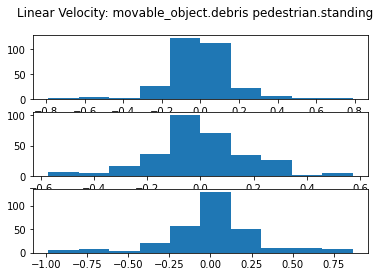

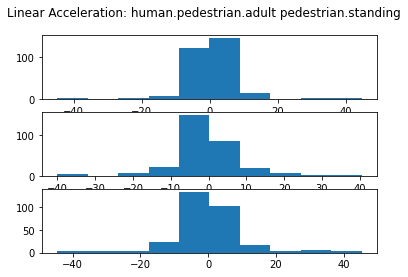

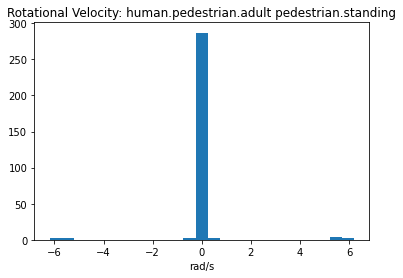

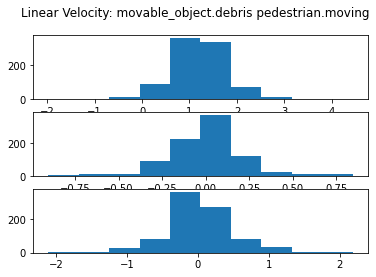

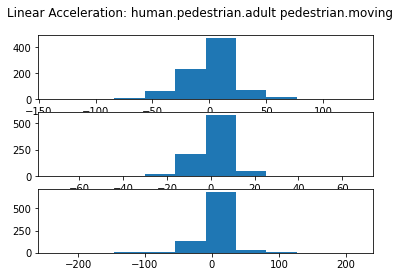

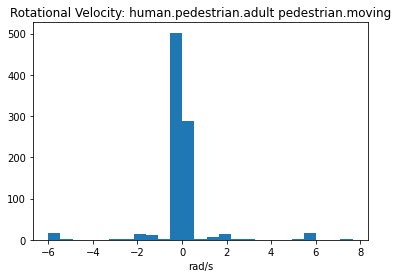

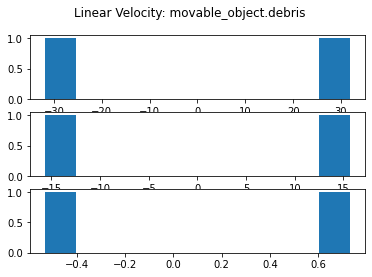

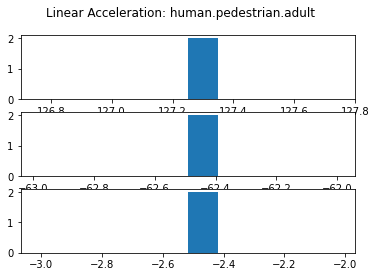

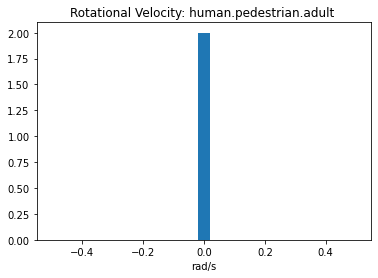

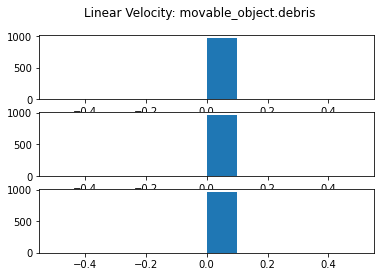

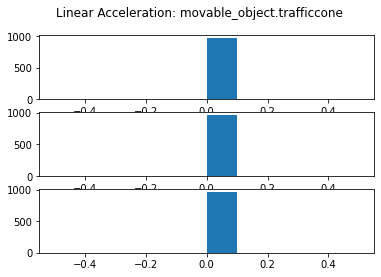

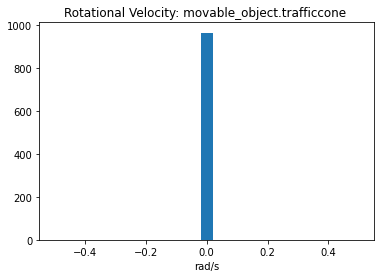

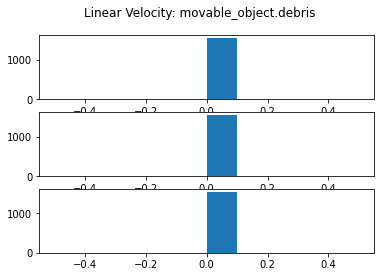

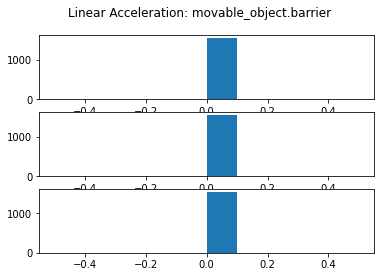

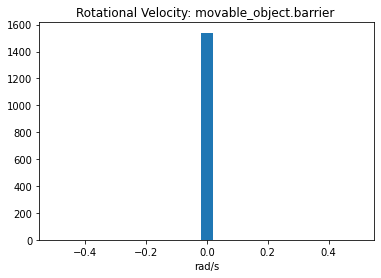

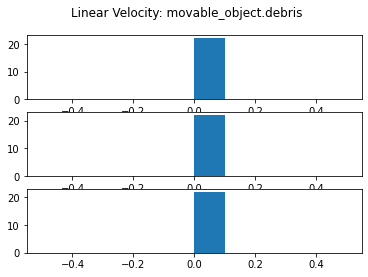

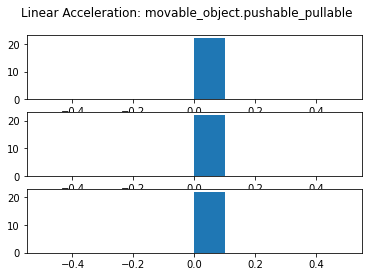

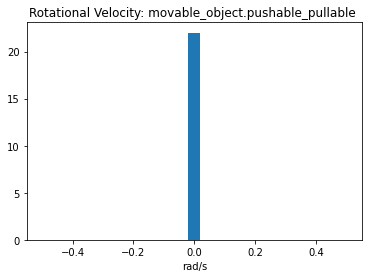

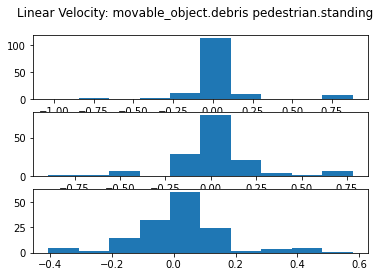

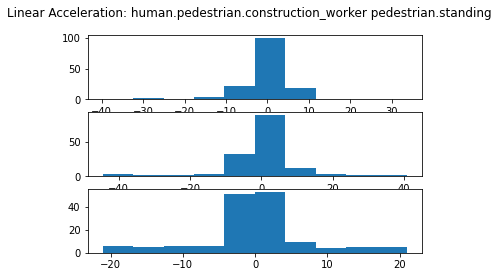

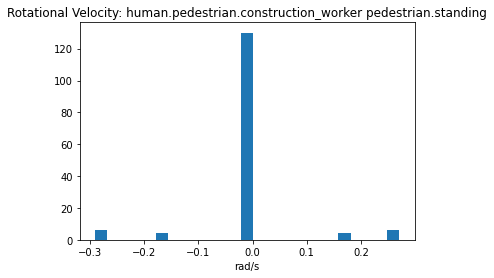

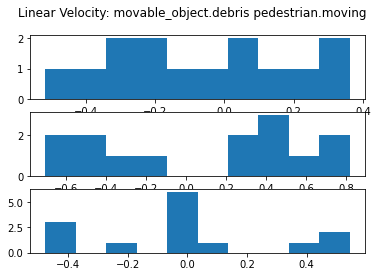

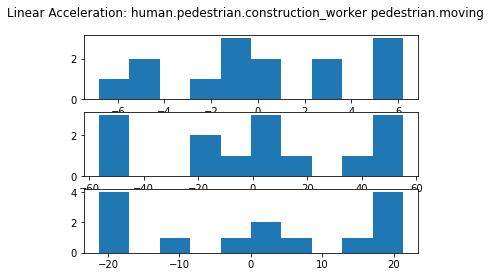

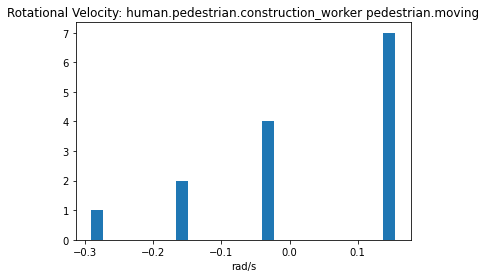

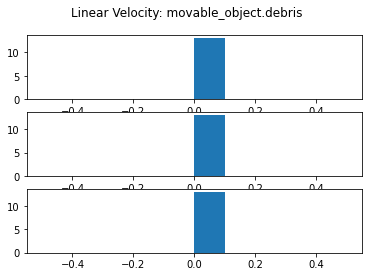

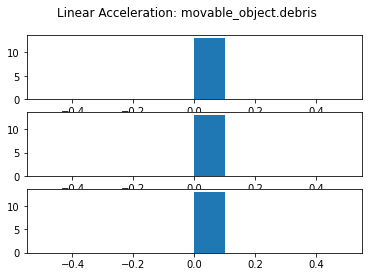

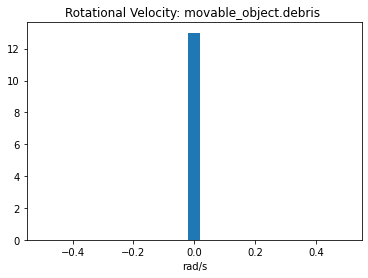

In [155]:
# TODO
# - multiple data series on same plot, with data legend/labels

def make_plots(class_att):
    
    for cls in class_att:
        for att in class_att[cls]:
    
            # make vel plot
            vel_fig, vel_axs = plt.subplots(3)
            vel_fig.suptitle('Linear Velocity: ' + str(class_type) + " " + str(att))
            vel_axs[0].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'vel_x'])
            vel_axs[1].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'vel_y'])
            vel_axs[2].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'vel_z'])

            # make acc plot
            acc_fig, acc_axs = plt.subplots(3)
            acc_fig.suptitle('Linear Acceleration: ' + str(cls) + " " + str(att))
            acc_axs[0].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'acc_x'])
            acc_axs[1].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'acc_y'])
            acc_axs[2].hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'acc_z'])

            # make omega plot
            omega_fig = plt.figure("Rotational Velocity")
            plt.hist(variable_df.loc[(variable_df['class']==cls) & (variable_df['attribute']==att),'omega_z'],25)
            plt.title("Rotational Velocity: " + str(cls) + " " + str(att))
            plt.xlabel("rad/s")
            plt.show()
    
    
class_att_dict = dict()
for class_type in variable_df['class'].unique():
    print(class_type)
    
#     for att in variable_df.loc[variable_df['class']==class_type,'attribute'].unique():
#         print(att)
    class_att_dict[class_type] = list(variable_df.loc[variable_df['class']==class_type,'attribute'].unique())
    
print(class_att_dict)
make_plots(class_att_dict)
    